<a href="https://colab.research.google.com/github/M2I-HABET/Mission-158/blob/devel-mnelson/Parse_HABET_FDR_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HABET Flight Data Recorder Parser
This notebook can be used to parse and display data that is recorded on both the High Altitude Reporter (HAR) and the Backup Emergency Recovery Transmitter (BERT). Both units use an Adafruit Clue board that is has 2MB of FLASH memory storage. This storage stores GPS data and sensor data from the Clue board.

As of 8/17/2021, the data is stored as a comma seperated values (csv) file and is formatted as follows:

$IDENT,TimeStamp,GPSLat,GPSLon,GPSAlt,GPSSats,Temp,Pressure,Humidity,MagX,MagY,MagZ,AccelX,AccelY,AccelZ,GyroX,GyroY,GyroZ,Light,#

IDENT refers to the device that is recording. This should be either HAR or BERT. TimeStampe is taken from the GPS unit. 

# Install
First we need to install some things that Google Colab doesn't have. Specifically we are going to install tilemapbase for mapping and simplekml for generating a KML file.

In [1]:
# Install tilemapbase
!pip install tilemapbase
!pip install simplekml

# Import
Are next step is to import the libraries we will be using.

In [2]:
# Import Mapping software
import tilemapbase

# Pandas for data analysis
import pandas as pd

# Setup Matplotlib to work in Jupyter notebooks
%matplotlib inline

#Import needed libraries, mainly numpy, matplotlib and datetime
import math
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import simplekml

# Import the Image function from the IPython.display module.
from IPython.display import Image

# Initial Conditions
It is useful to a few variables now so you don't need to worry about them later. This way you can set these now and then just run the entire notebook. We will set the following variables:

- Launch Location (latitude,longitude)
- Launch date/time (month-day-year HH:MM:SS)
- Flight ID (ex. L-158-D)

In [3]:
# Launch Coordinates in Decimal Degress
launch_loc = (41.59189627804254, -93.55588561331234)

#Flight ID - Example LX-158-C
flight_id = 'L-158-D'

#time1  = datetime.strptime('8-01-2008 00:00:00', date_format)
#set the date and time format
date_format = "%m-%d-%Y %H:%M:%S"
launch_time = datetime.strptime('8-15-2021 09:25:00',date_format)

## Access our Data

We need to access our data which is stored as csv files. I have uploaded this file to my Google drive. In Google Colaboratory, we can access our Google Drive files use the code below. 

In [4]:
# Mount our Google Drive so we can access files there

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Read and Parse the file

We can use Pandas to read the CSV files and store them as a Pandas Dataframe. The CSV files do not have headers on them. So, we will also go ahead and add labels for the columns as well.

In [5]:
har_df = pd.read_csv("/content/gdrive/My Drive/Data/HAR_L-158-D.csv")
bert_df = pd.read_csv("/content/gdrive/My Drive/Data/BERT_L-158-D.csv")
har_df.columns =['Ident', 'Lat', 'Lon', 'Altitude','Temp','Pressure','Humidity','Close']
bert_df.columns = ['Temp', 'Pressure', 'Humidity', 'Lat','Lon','Altitude','GPS']

Now that we have our Dataframes, the data stored does need to have some calculations done to it. Latitude and Longitude data is stored as integer values so it is easier for our microcontroler to work with. To convert this to Decimal Degrees, we simply divide the value by 10000000. Our atltiude is stored in millimeters, to convert to meters, we simply divide by 1000. 

In [6]:
har_temp = har_df.Temp
bert_temp = bert_df.Temp
har_humidity = har_df.Humidity
har_pressure = har_df.Pressure
bert_humidity = bert_df.Humidity
bert_pressure = bert_df.Pressure
har_lat = har_df.Lat / 10000000
bert_lat = bert_df.Lat / 10000000
har_lon = har_df.Lon / 10000000
bert_lon = bert_df.Lon / 10000000
har_alt = har_df.Altitude / 1000
bert_alt = bert_df.Altitude / 1000

# Flight Information
We can now do some calculations on a few stats on the flights. Let's start by calculating the flight time. BERT records at 1 sec intervals so we can list the launch time based on the information provided and then how many data points were recorded.

In [7]:
print("Launch date is:",launch_time.date())
print("Launch time is:",launch_time.time())
time_sec = len(bert_df)
flight_time = timedelta(seconds=time_sec)
landing_time = launch_time+timedelta(seconds=time_sec)
print("Flight time is:",flight_time)
print("Landing time is:",landing_time)

Launch date is: 2021-08-15
Launch time is: 09:25:00
Flight time is: 2:45:25
Landing time is: 2021-08-15 12:10:25


## Distance
We can also look at the Launch location and final landing coordinates to get our distance.

In [8]:
from math import radians, sin, cos, acos, atan2,sqrt

# approximate radius of earth in km
R = 6373.0

lat1 = radians(launch_loc[0])
lon1 = radians(launch_loc[1])
lat2 = radians(bert_lat.iloc[-1])
lon2 = radians(bert_lon.iloc[-1])

dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c

print("Result: %.2f km" % distance)


Result: 40.64 km


# Minimum and Maximum Data points
Before we graph the data, let's look at some minimum and maximum data points that was collected. There are a few things that should be noted with this data. First, the data was recorded using the Adafruit Clue board. There will be some self-heating due to where the sensor is on the printed circuit board. HAR was located in the payload and heating from itself and the Raspberry Pi 4 Compute Module, the on board power supply and the Rocket M5 wireless transmitter will all contribute quite a bit of heat.

BERT on the other hand was located outside of the payload and has a lot less insulation around it. It was enclosed in a small Pelican case. There may be some heating affects from the clear cover that could give a bit of a greenhouse affect, but as you can see, had much wider temperature swings than in the payload. This was to be expected.

## Min/Max Temperature
Below is the minimum and maximum temperatures on both the payload and BERT.

In [30]:
print("The maximum temperature recorded inside the payload was",har_temp.max(),"C")
print("The minimum temperature recorded inside the payload was",har_temp.min(),"C")
print("The maximum temperature recorded inside BERT was",bert_temp.max(),"C")
print("The minimum temperature recorded inside BERT was",bert_temp.min(),"C")

The maximum temperature recorded inside the payload was 36.55 C
The minimum temperature recorded inside the payload was 18.48 C
The maximum temperature recorded inside BERT was 31.81 C
The minimum temperature recorded inside BERT was -11.13 C


## Min/Max Humidity

In [31]:
print("The maximum humidity recorded inside the payload was",har_humidity.max(),"%")
print("The minimum humidity recorded inside the payload was",har_humidity.min(),"%")
print("The maximum humidity recorded inside BERT was",bert_humidity.max(),"%")
print("The minimum humidity recorded inside BERT was",bert_humidity.min(),"%")

The maximum humidity recorded inside the payload was 53.97 %
The minimum humidity recorded inside the payload was 0.0 %
The maximum humidity recorded inside BERT was 61.83 %
The minimum humidity recorded inside BERT was 4.82 %


## Min/Max Dewpoint
Since we have both humidity and temperature, we can also calculate the dewpoint. Dewpoint is calculated as below.

$T_{temp} - (\frac{(100 - H_{humidity})}{5})$

In [32]:
print("The maximum dewpoint recorded inside the payload was {:.2f} C".format(har_temp.max()-((100 - har_humidity.max())/5.0)))
print("The minimum dewpoint recorded inside the payload was {:.2f} C".format(har_temp.min()-((100 - har_humidity.min())/5.0)))
print("The maximum dewpoint recorded inside BERT was {:.2f} C".format(bert_temp.max()-((100 - bert_humidity.max())/5.0)))
print("The minimum dewpoint recorded inside BERT was {:.2f} C".format(bert_temp.min()-((100 - bert_humidity.min())/5.0)))

The maximum dewpoint recorded inside the payload was 27.34 C
The minimum dewpoint recorded inside the payload was -1.52 C
The maximum dewpoint recorded inside BERT was 24.18 C
The minimum dewpoint recorded inside BERT was -30.17 C


## Min/Max Pressure

In [33]:
print("The maximum pressure recorded inside the payload was",har_pressure.max(),"hPa")
print("The maximum pressure recorded inside BERT was",bert_pressure.max(),"hPa")
print("The minimum pressure recorded inside the payload was",har_pressure.min(),"hPa")
print("The minimum pressure recorded inside BERT was",bert_pressure.min(),"hPa")

The maximum pressure recorded inside the payload was 995.73 hPa
The maximum pressure recorded inside BERT was 996.4 hPa
The minimum pressure recorded inside the payload was 9.63 hPa
The minimum pressure recorded inside BERT was 9.3 hPa


## Maximum Altitude

In [37]:
print("The maximum altitude obtained is",har_alt.max(),"m, or",(har_alt.max()*3.2808),"ft")

The maximum altitude obtained is 36741.394 m, or 120541.1654352 ft


# Graphing
Both BERT and HAR record a number of data points from their internal sensors. Because HAR's primary function is to communicate back to Mission Control and to manage other functions on the spacecraft, HAR only records data at 5 second intervals so that other clock cycles are used for other functions which have a higher priority. BERT on the other hand has the sole purpose of communicating it's position via satellite and that only happens around 3 minute intervals. The rest of the time it is idle. Due to that, BERT records data at 1 second intervals. 

The following graphs are from the Clue boards internal Temperature, Humidity, and Pressure sensors. HAR is located inside the spacecraft and is mostly shielded from direct light and the foam around the spacecraft does provide insulation. The spacecraft is not sealed, so pressure will adjust based on external pressure. 

BERT is located in a semi-sealed Pelican case that is located further up the stack line between the parachute and the spacecraft. This case has a clear top so solar energy can be absorbed. While this is a Pelican case, the case has a pressure relief valve. The case is also compromised, where we drilled a hole for a SMA connector so it is not airtight. 

Both units were turned on and off within a few seconds of each other. It should be notied that temperature will be off due to self-heating of the sensor and heat generated from the microcontroller. This generally adds 1-4 C to our readings.

## Altitude
Let's start by graphing the altitude. This altitude is based from the GPS sensor and not from the pressure sensor with this current version.

One thing to note is how quickly the spacecraft descends after burst. This is normal as the parachute needs to have denser air before it becomes effective at slowing down the spacecraft. This typically starts around 60,000 feet.

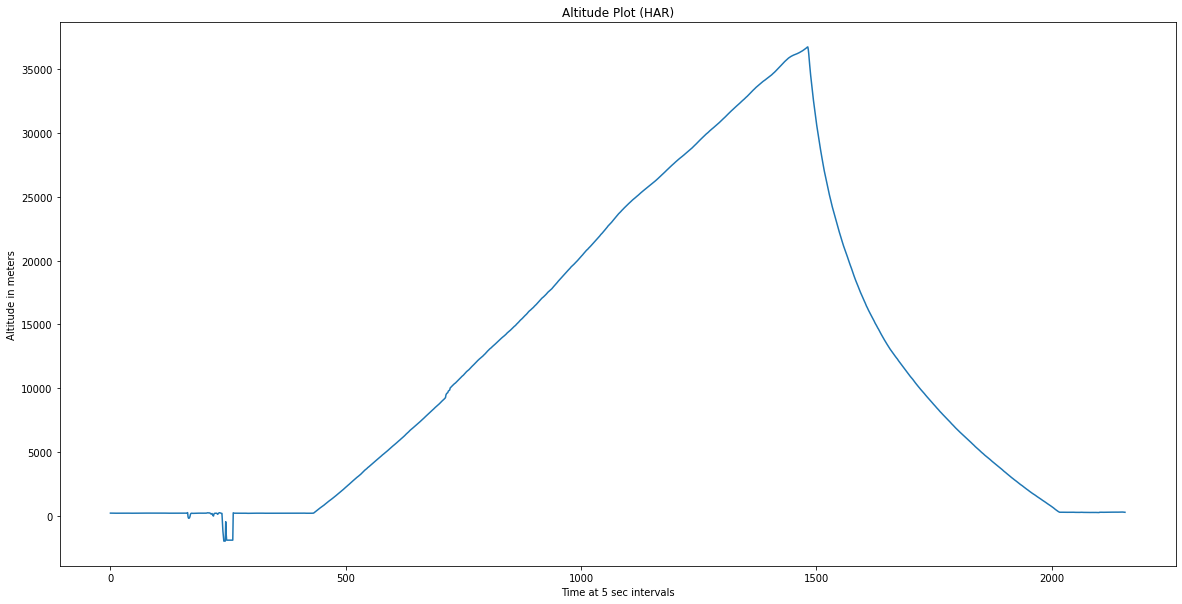

In [10]:
har_alt.plot(title="Altitude Plot (HAR)",ylabel="Altitude in meters",xlabel="Time at 5 sec intervals",figsize=(20, 10));
plt.savefig('/content/gdrive/My Drive/har_alt_plot.pdf',bbox_inches = "tight",dpi = 500)

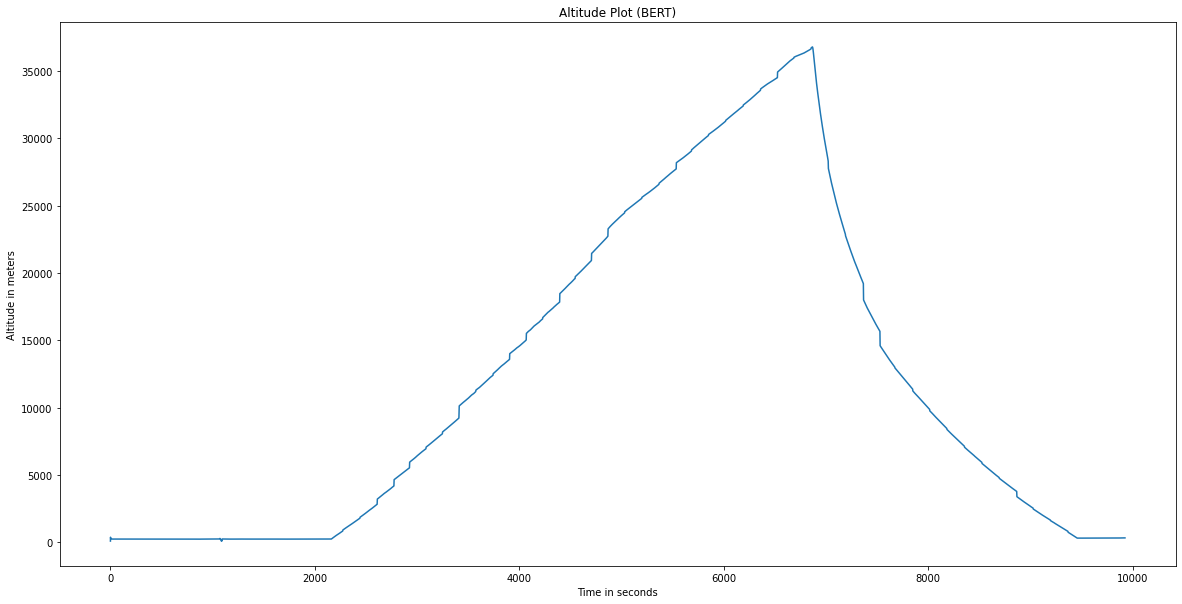

In [11]:
bert_alt.plot(title="Altitude Plot (BERT)",ylabel="Altitude in meters",xlabel="Time in seconds",figsize=(20, 10));
plt.savefig('/content/gdrive/My Drive/bert_alt_plot.pdf',bbox_inches = "tight",dpi = 500)

## Temperature
Again, note that HAR is located in the spacecraft and BERT is located in a Pelican case between the spacecraft and the parachute. BERT does not have insulation around it, so it recorded colder temperatures than HAR that is located in the insulated spacecraft. Please note that the temperature increase is due to a temperature inversion that natually occurs in the atmosphere.

In addition to the insulation, HAR is near equipment that generates a lot more heat than what BERT has. The Raspberry Pi Compute Module 4 and the Rocket M5 both generate quite a bit of heat during normal operation. This adds to the temperature inside the spacecraft.

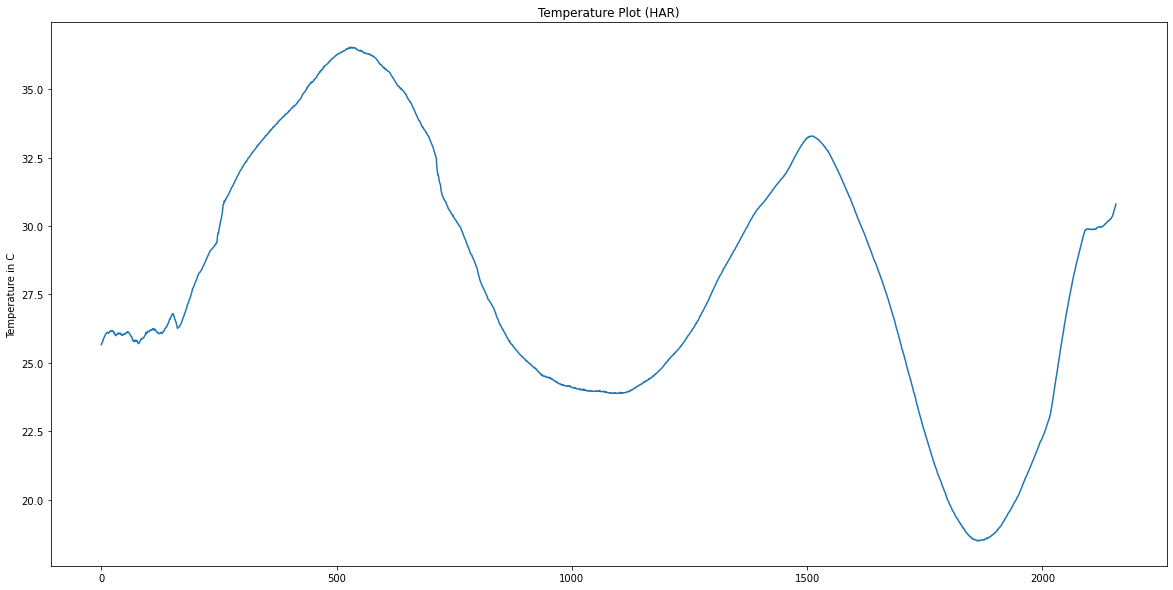

In [12]:
har_temp.plot(title="Temperature Plot (HAR)",ylabel="Temperature in C",figsize=(20, 10));
plt.savefig('/content/gdrive/My Drive/har_temp_plot.pdf',bbox_inches = "tight",dpi = 500)

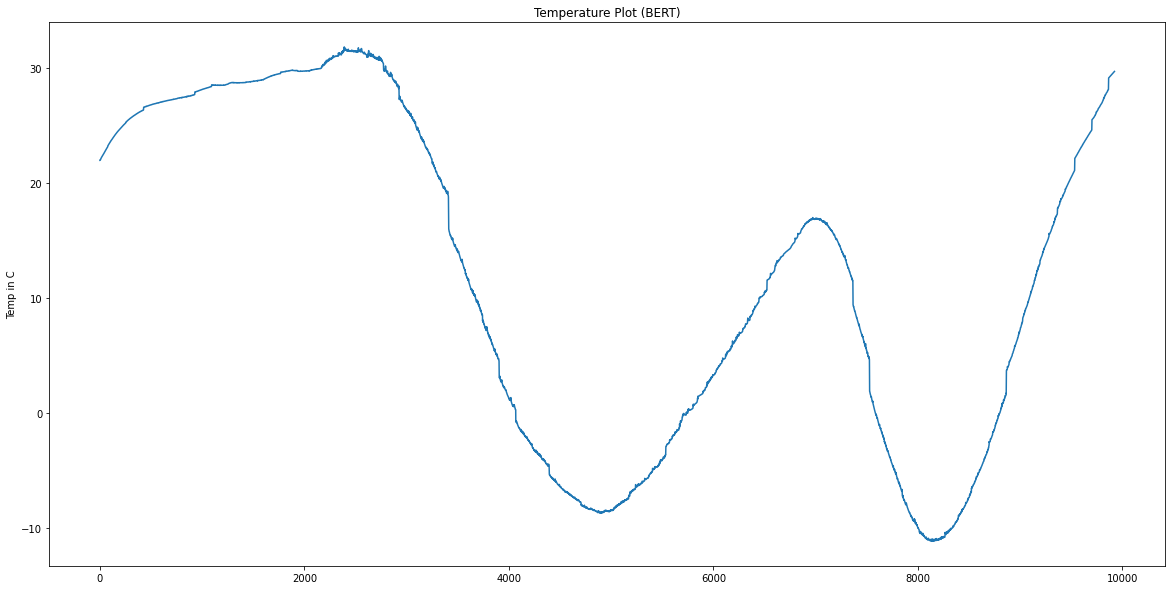

In [13]:
bert_df.Temp.plot(title="Temperature Plot (BERT)",ylabel="Temp in C",figsize=(20, 10));
plt.savefig('/content/gdrive/My Drive/bert_temp_plot.pdf',bbox_inches = "tight",dpi = 500)

## Humidity
Below is the Humidity readings from both HAR and BERT. BERT had higher readings probably due to the case it was in which was much more confined and probably had more of the higher humidity air from the ground still trapped in it. The spacecraft was probably able to vent more of this out and once it hit the drier colder air lost almost all of the humidity.

This is probably the reason that we did not experience much condensation in the video from the flight. The air was already fairly dry and remained dry until we were back on the ground.

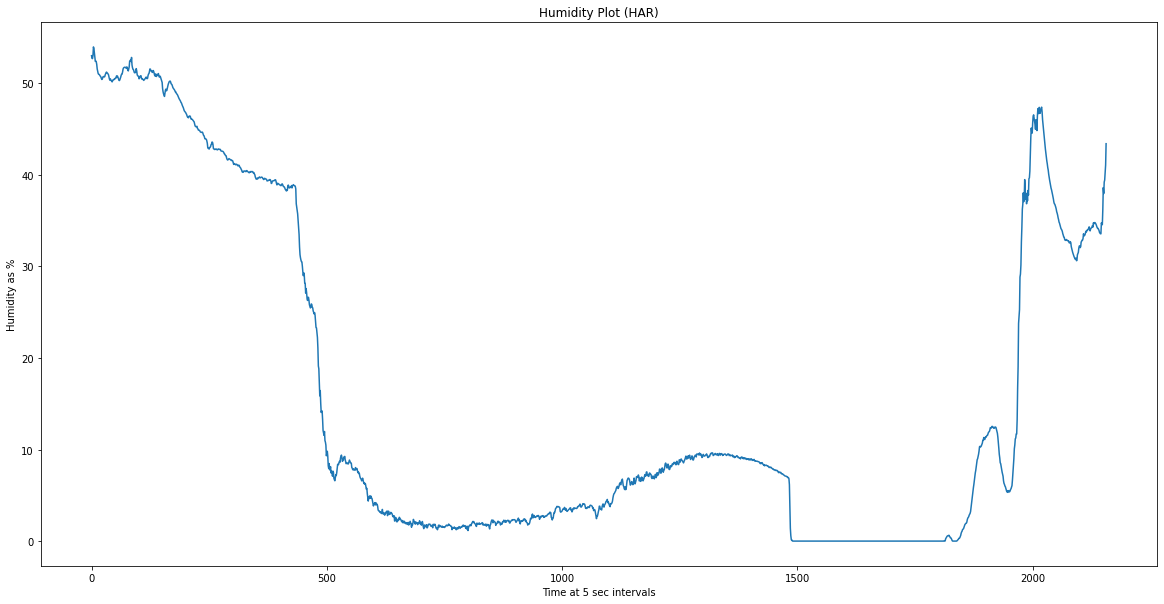

In [14]:
har_df.Humidity.plot(title="Humidity Plot (HAR)",ylabel="Humidity as %",xlabel="Time at 5 sec intervals",figsize=(20, 10));
plt.savefig('/content/gdrive/My Drive/har_alt_plot.pdf',bbox_inches = "tight",dpi = 500)

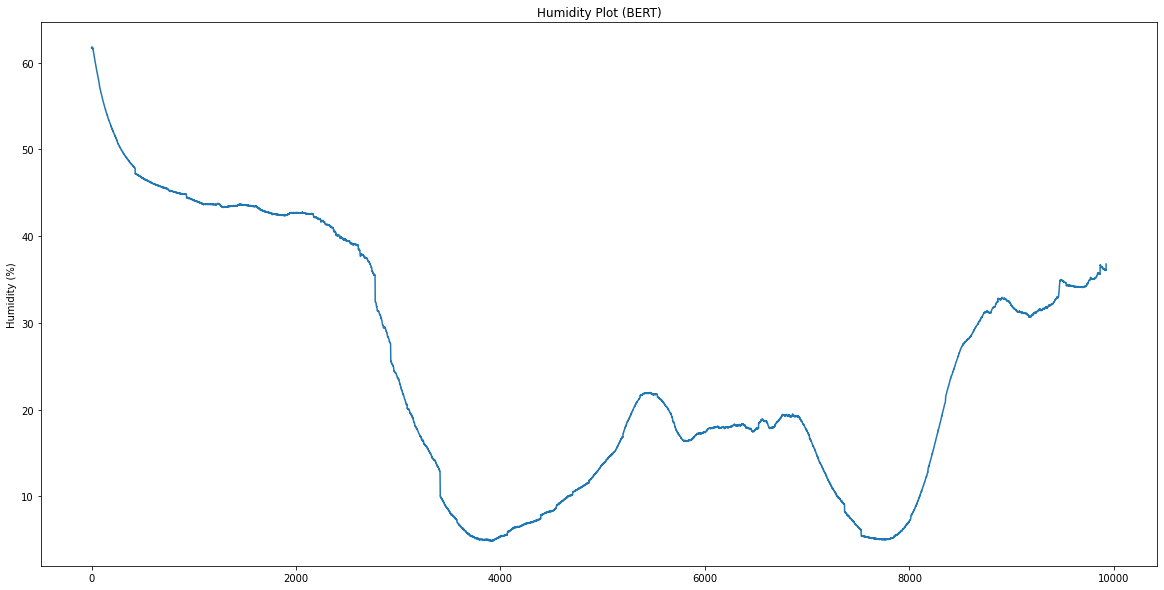

In [15]:
bert_df.Humidity.plot(title="Humidity Plot (BERT)",ylabel="Humidity (%)",figsize=(20, 10));
plt.savefig('/content/gdrive/My Drive/bert_humidity_plot.pdf',bbox_inches = "tight",dpi = 500)

## Pressure
The pressure sensor on the Clue board is not rated to zero pressure and so there is a chance that there are some errors in these readings. BERT also is in a case that while not airtight, is somewhat sealed and so there was probably a delay as the pressure equalized between inside the case and outside. Still, the profile that we see here is typical for what we see on most flights. 

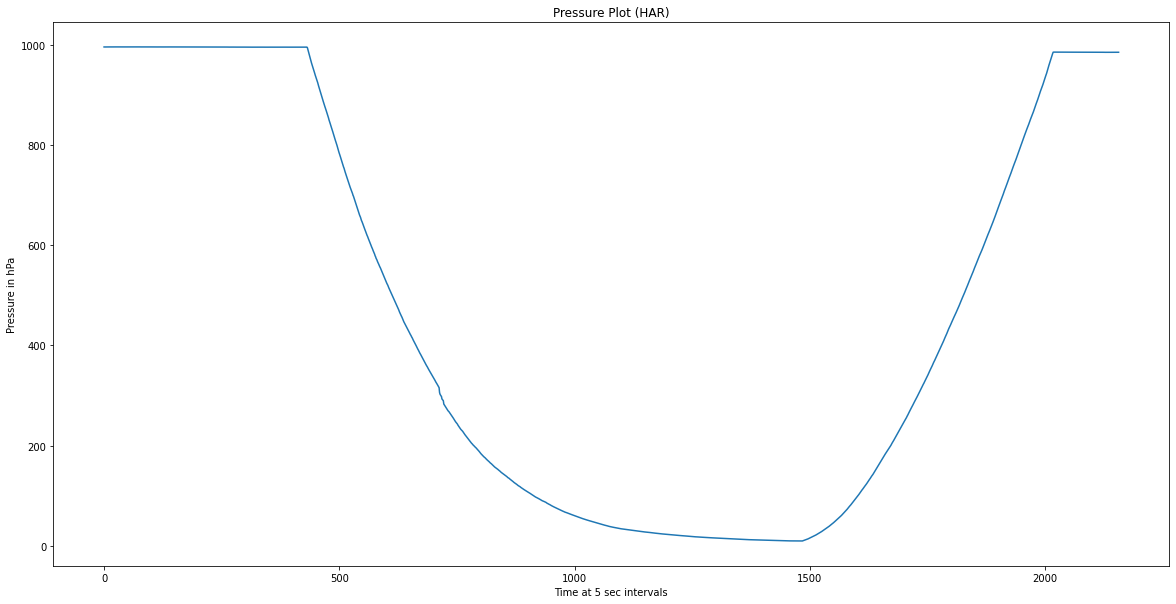

In [16]:
har_df.Pressure.plot(title="Pressure Plot (HAR)",ylabel="Pressure in hPa",xlabel="Time at 5 sec intervals",figsize=(20, 10));
plt.savefig('/content/gdrive/My Drive/har_pressure_plot.pdf',bbox_inches = "tight",dpi = 500)

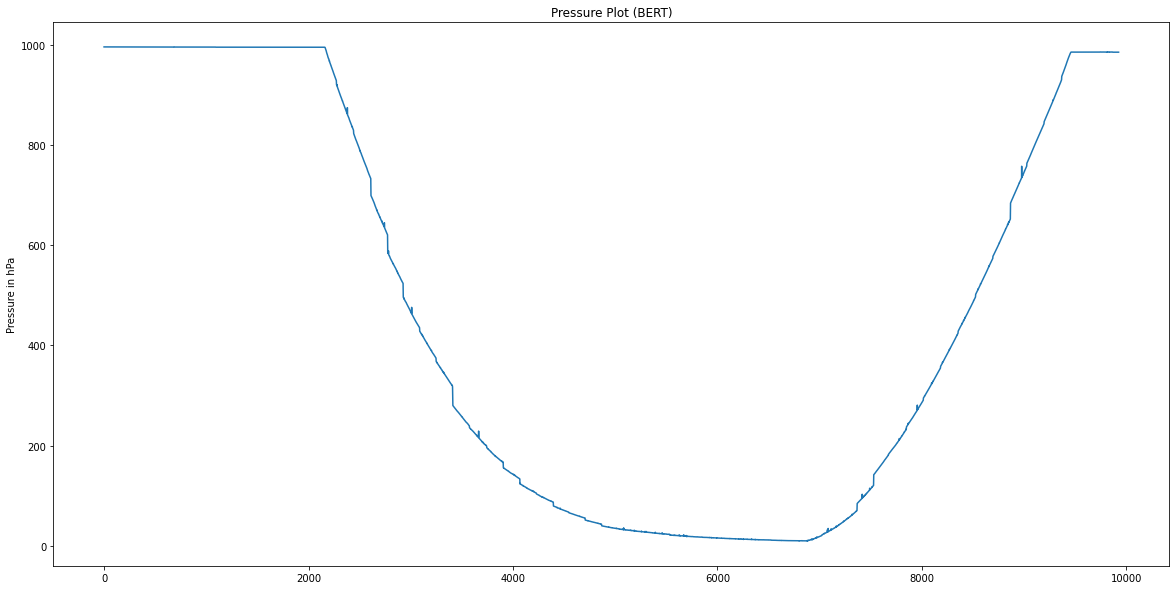

In [17]:
bert_df.Pressure.plot(title="Pressure Plot (BERT)",ylabel="Pressure in hPa",figsize=(20, 10));
plt.savefig('/content/gdrive/My Drive/bert_pressure_plot.pdf',bbox_inches = "tight",dpi = 500)

## Temp vs Altitude
It's useful to look at this data vs Altitude. 

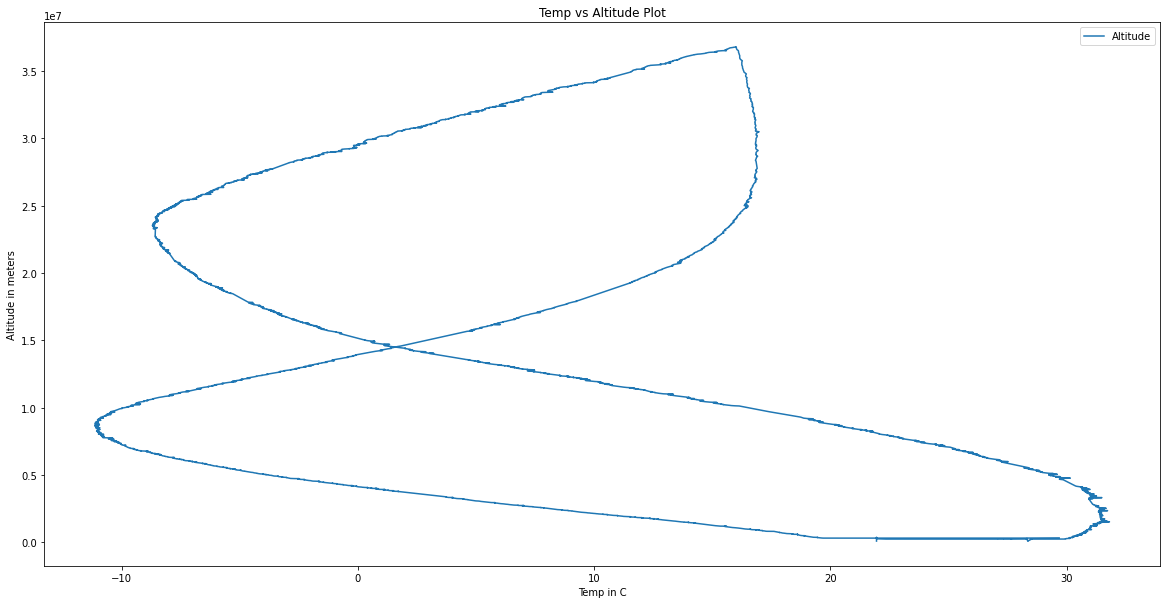

In [18]:
bert_df.plot(title="Temp vs Altitude Plot",ylabel="Altitude in meters",xlabel="Temp in C",x="Temp",y="Altitude",figsize=(20, 10))
plt.savefig('/content/gdrive/My Drive/bert_tempalt_plot.pdf',bbox_inches = "tight",dpi = 500)

## Pressure vs. Altitude

In lower altitudes you can see there is a linear relationship between pressure and altitude. This is why pressure sensors are often used as altimeters as they are more accurate then even GPS.

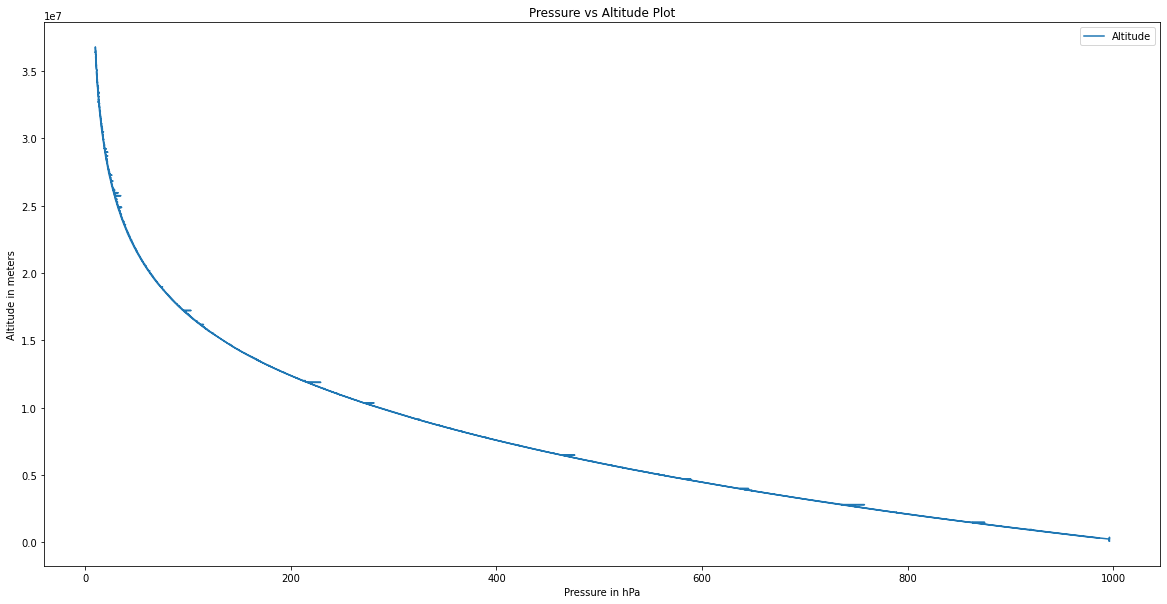

In [19]:
bert_df.plot(title="Pressure vs Altitude Plot",ylabel="Altitude in meters",xlabel="Pressure in hPa",x="Pressure",y="Altitude",figsize=(20, 10))
plt.savefig('/content/gdrive/My Drive/bert_pressurealt_plot.pdf',bbox_inches = "tight",dpi = 500)

Ok, let's print one of these and make sure it looks right.

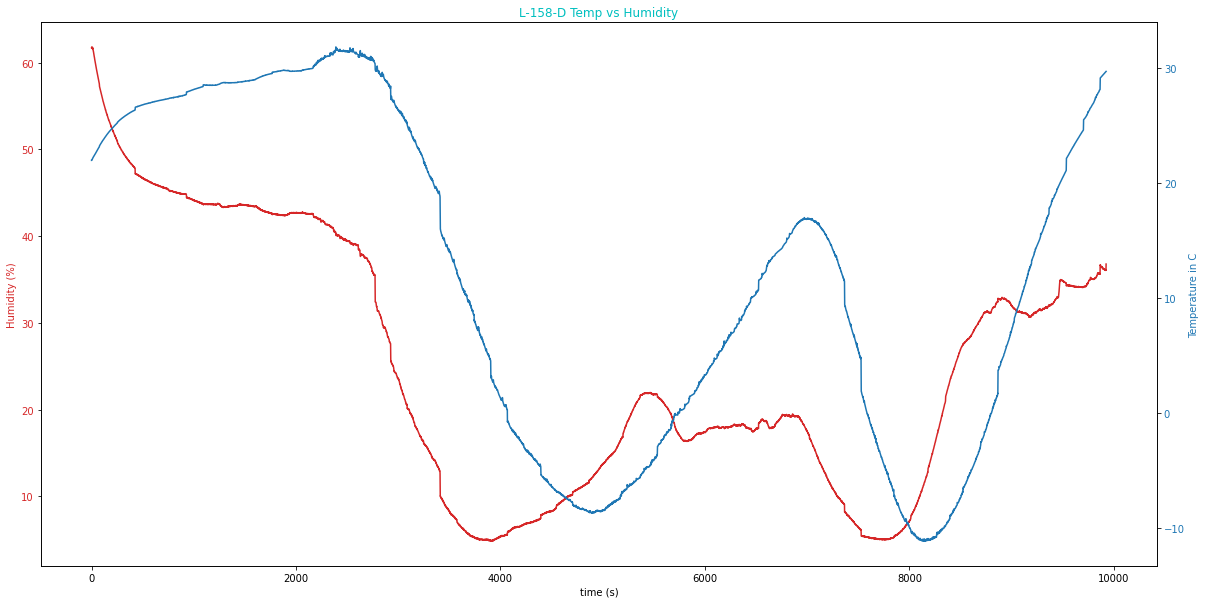

In [20]:
# Setup fixed points for graphing with

# Turn on subplots
fig, ax1 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Humidity (%)', color=color)
ax1.plot(bert_df.Humidity,color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Temperature in C', color=color)  # we already handled the x-label with ax1
ax2.plot(bert_df.Temp)
ax2.tick_params(axis='y', labelcolor=color)

# Always have a good title
plt.title("L-158-D Temp vs Humidity",color='c')
# This allows us to save our pretty graph so we can frame it later
plt.savefig('/content/gdrive/My Drive/temp_humidity.pdf',bbox_inches = "tight",dpi = 500)

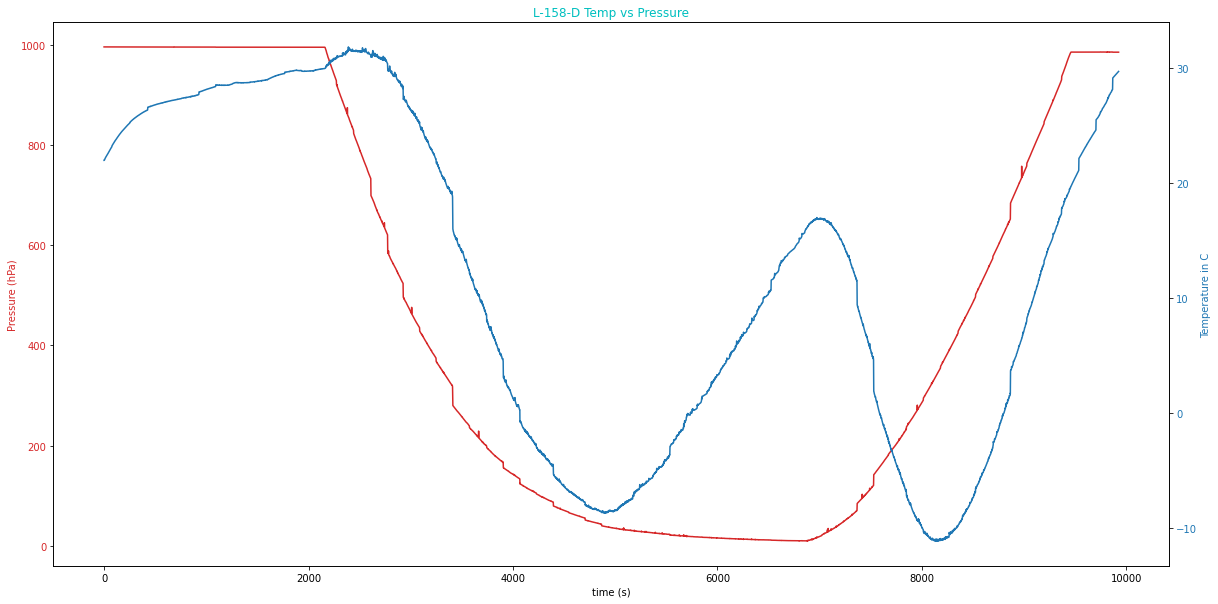

In [21]:
# Setup fixed points for graphing with

# Turn on subplots
fig, ax1 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Pressure (hPa)', color=color)
ax1.plot(bert_df.Pressure,color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Temperature in C', color=color)  # we already handled the x-label with ax1
ax2.plot(bert_df.Temp)
ax2.tick_params(axis='y', labelcolor=color)

# Always have a good title
plt.title("L-158-D Temp vs Pressure",color='c')
# This allows us to save our pretty graph so we can frame it later
plt.savefig('/content/gdrive/My Drive/temp_pressure.pdf',bbox_inches = "tight",dpi = 500)

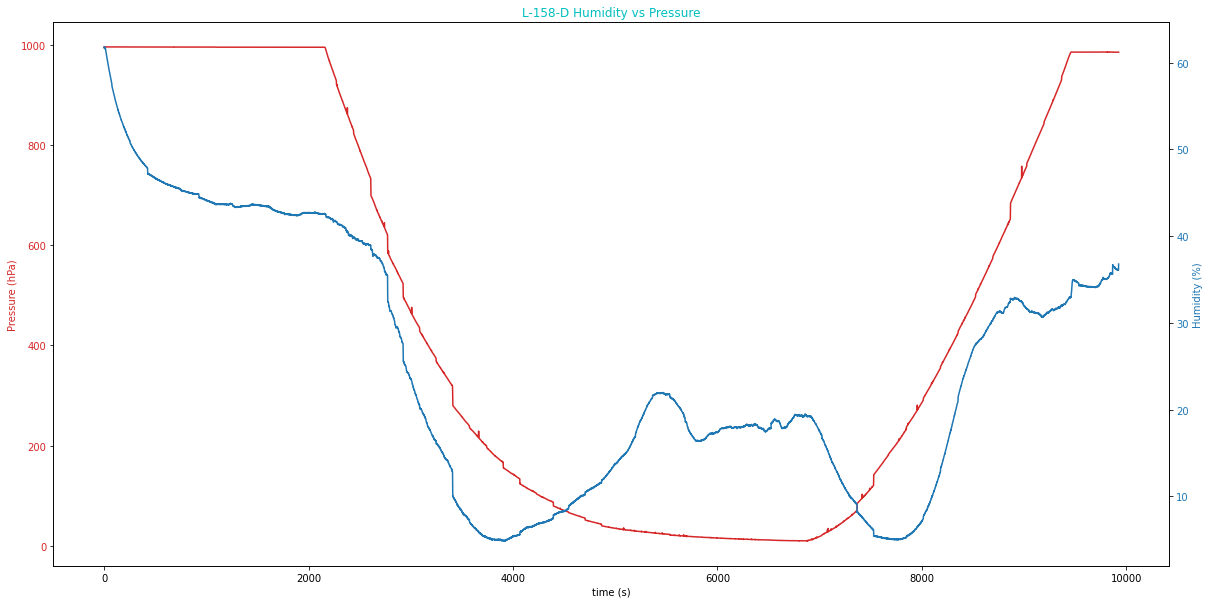

In [22]:
# Setup fixed points for graphing with

# Turn on subplots
fig, ax1 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Pressure (hPa)', color=color)
ax1.plot(bert_df.Pressure,color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Humidity (%)', color=color)  # we already handled the x-label with ax1
ax2.plot(bert_df.Humidity)
ax2.tick_params(axis='y', labelcolor=color)

# Always have a good title
plt.title("L-158-D Humidity vs Pressure",color='c')
# This allows us to save our pretty graph so we can frame it later
plt.savefig('/content/gdrive/My Drive/humidity_pressure.pdf',bbox_inches = "tight",dpi = 500)

# Mapping the data
Let's map the data. There are a couple of ways to do this. First, we can save the information as a Keyhole Markup Language (KML). This format is then easy to import into Google Maps or Google Earth. Other systems can import a KML file. 

The second method is to actually map the data and for that we can use timemapbase which will download map tiles from Open Street Maps.

Let's save the data back into the dataframe. Lon and Lat are stored as integers and need to be converted to decimal degress. This is easily done by taking the value and dividing it by 10000000. The Altitude is in millimeters, and we can convert this to meters by dividing it by 1000.

In [23]:
bert_df["Lon"] /= 10000000
bert_df["Lat"] /= 10000000
bert_df["Altitude"] /= 1000


Now, we can plot the Lat/Lon using Tilemaps. We need to start by initializing timemapbase.


In [24]:
tilemapbase.init(create=True)

# Create KML file
A KML file allows us to import the path of the spacecraft into other programs. This allows us to make the KML file and save it.

In [25]:
kml = simplekml.Kml()
linestring = kml.newlinestring(name=flight_id)
bert_df.apply(lambda X: linestring.coords.addcoordinates([( X["Lon"],X["Lat"],X["Altitude"])]) ,axis=1)

linestring.altitudemode = simplekml.AltitudeMode.relativetoground
linestring.extrude = 1
linestring.linestyle.color = simplekml.Color.green
linestring.linestyle.width = 5
linestring.polystyle.color = simplekml.Color.orange
#pol = kml.newpolygon(name= 'ACTONO', description= 'Acton County', 
#outerboundaryis=tuples, extrude=extrude, altitudemode=altitudemode)

#Styling colors
#pol.style.linestyle.color = simplekml.Color.green
#pol.style.linestyle.width = 5
#pol.style.polystyle.color = simplekml.Color.changealphaint(100, 
#simplekml.Color.green)

#Saving
kml.save("/content/gdrive/My Drive/flight.kml")

## KML on display
You can see this KML file in action here 
[HABET Flight L-158-D on Google Maps](https://www.google.com/maps/d/u/0/edit?mid=1kmNp71h18NLEnd1AcFXASQY5rvfCthjX&usp=sharing)

#Map the data
We can start by graphing the latitude and longitude data. This clearly shows the path, but without a map it does not give us a reference to things such as streets and other features.

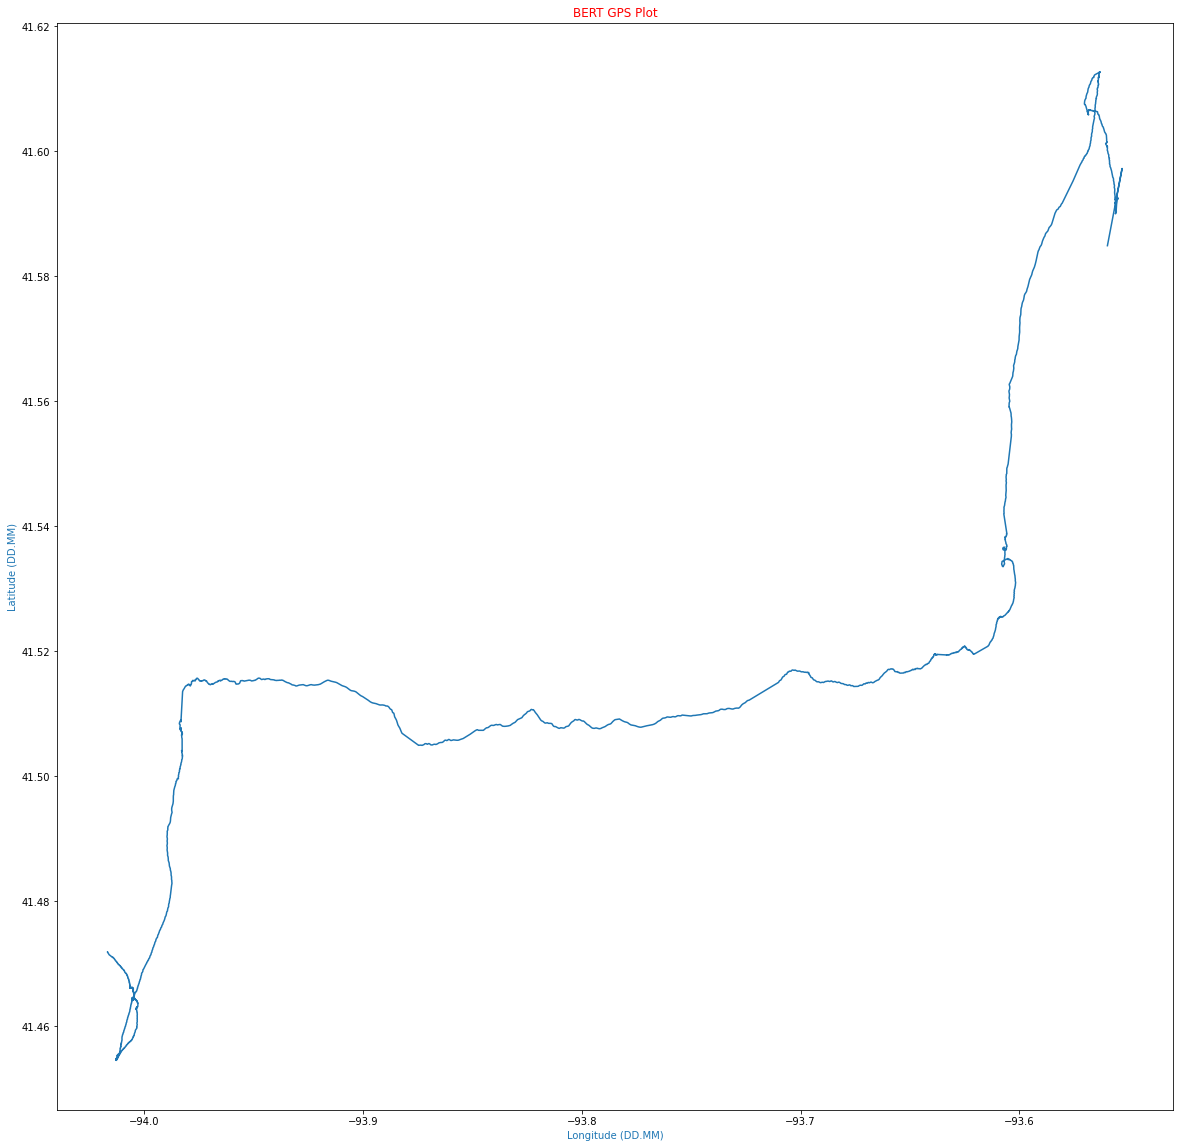

In [26]:
fig = plt.figure(figsize=(20, 20))
# Always have a good title and labels
plt.ylabel('Latitude (DD.MM)', color=color)
plt.xlabel('Longitude (DD.MM)', color=color)

plt.title("BERT GPS Plot",color='r')
plt.plot(bert_lon,bert_lat)
plt.savefig('/content/gdrive/My Drive/l158d_plot_nomap.pdf',bbox_inches = "tight",dpi = 500)

## 3D plot
We can do a 3D plot that has the latitude, longitude and altitude. Again, there is no map for a reference but it does give us a fairly good picture of what the flight path looked like.

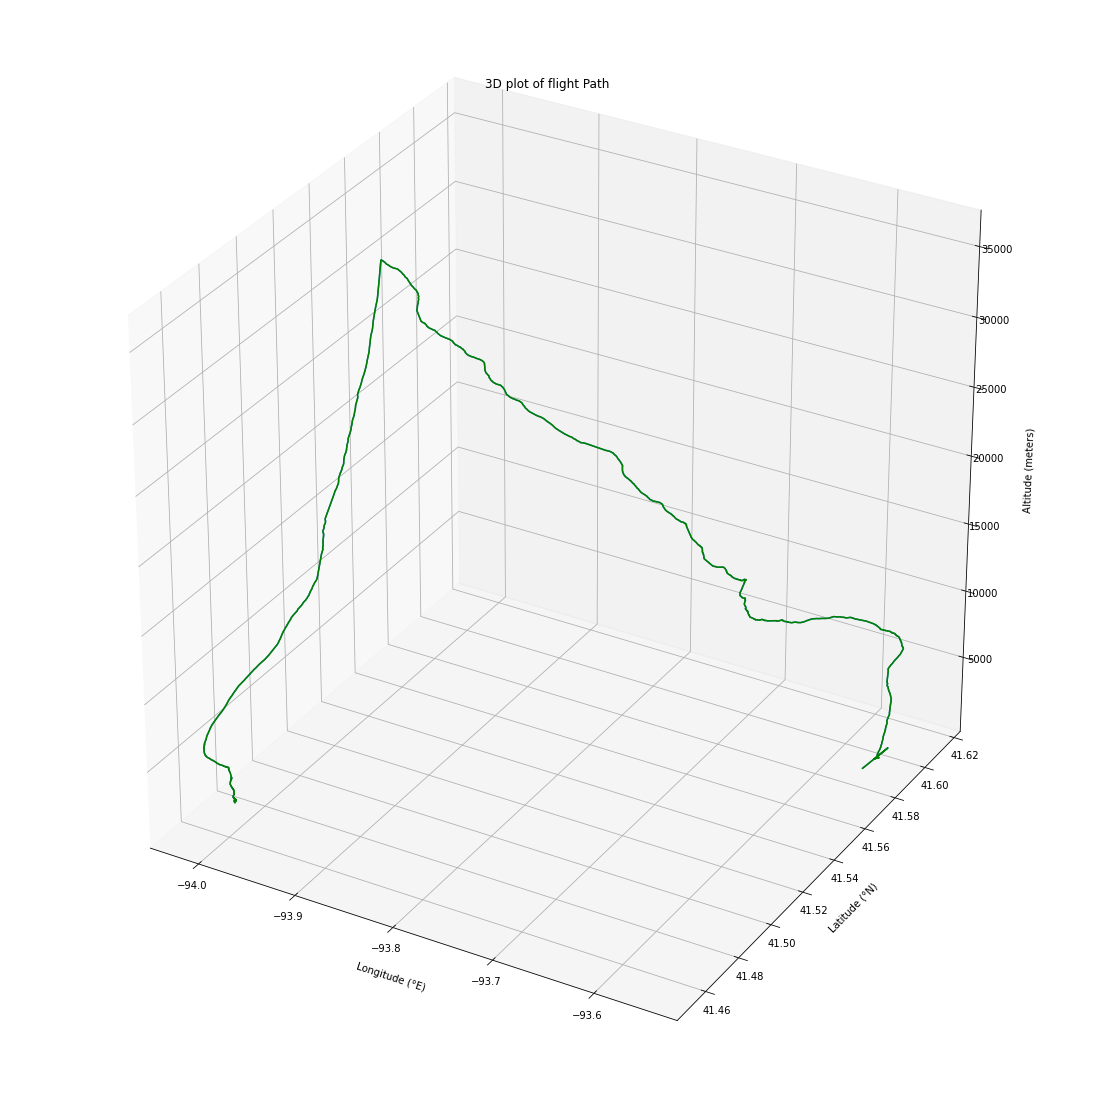

In [27]:
from mpl_toolkits.mplot3d import Axes3D

ur = (42.133700, -93.494635)
ll = (42.042358, -93.692460)
fig = plt.figure(figsize=(15, 15))
ax = Axes3D(fig)
ax.plot3D(bert_lon,bert_lat,bert_alt)

ax.set_title(u'3D plot of flight Path')
ax.set_xlabel(u'Longitude (°E)', labelpad=10)
ax.set_ylabel(u'Latitude (°N)', labelpad=10)
ax.set_zlabel(u'Altitude (meters)', labelpad=20)
ax.plot3D(bert_lon, bert_lat, bert_alt, color = 'green', lw = 1.5)
plt.savefig('/content/gdrive/My Drive/3D_View.pdf',bbox_inches = "tight",dpi = 300)

## Mapping using BaseMaps
We can use timemapbase to download Open Street Map tiles. We will center this map on the launch location.

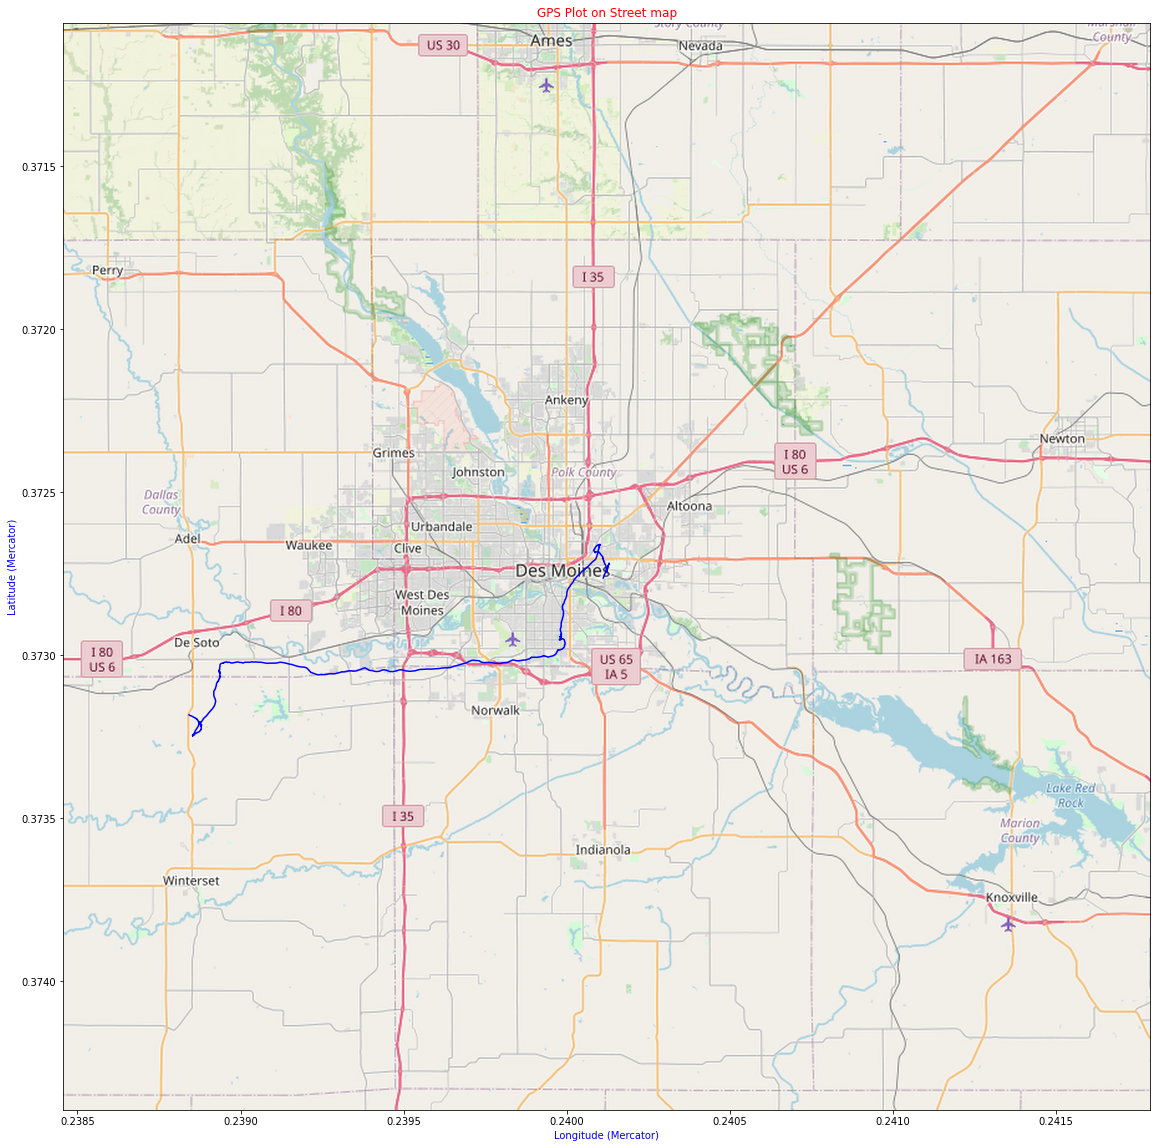

In [28]:
# Define the `extent`
color='blue'

# Zoom, the higher the number the zoomed out it will be. This is centered on
# the launch location
degree_range = 0.6

extent = tilemapbase.Extent.from_lonlat(launch_loc[1] - degree_range, launch_loc[1] + degree_range,
                  launch_loc[0] - degree_range, launch_loc[0] + degree_range)
extent = extent.to_aspect(1.0)

# Convert to web mercator
path = [tilemapbase.project(x,y) for x,y in zip(bert_lon, bert_lat)]
x, y = zip(*path)

fig, ax = plt.subplots(figsize=(20,20))

plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=800)
plotter.plot(ax)
plt.ylabel('Latitude (Mercator)', color=color)
plt.xlabel('Longitude (Mercator)', color=color)

plt.title("GPS Plot on Street map",color='r')

ax.plot(x, y,"b-")
plt.savefig('/content/gdrive/My Drive/l158d_plot_map.pdf',bbox_inches = "tight",dpi = 300)

## Zooming in
We can zoom in, let's zoom in on the landing area. To do this we will change the center area based on the last longitutde and latitude recorded which is at the end of the flight. 

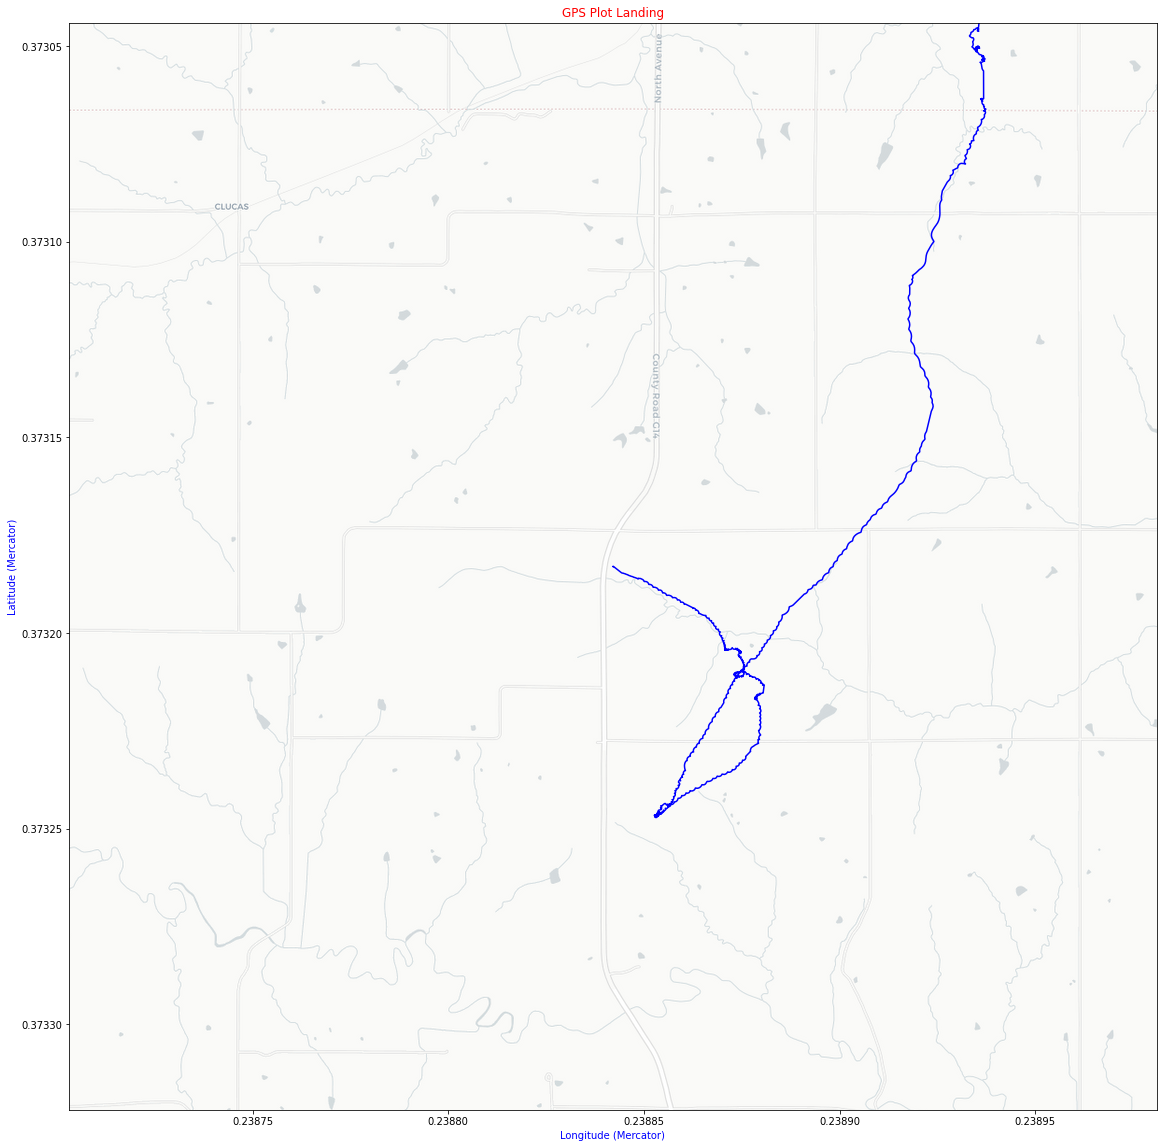

In [29]:
# Define the `extent`
color='blue'

# Zoom, the higher the number the zoomed out it will be. This is centered on
# the landing location
degree_range = 0.05

extent = tilemapbase.Extent.from_lonlat(bert_lon.iloc[-1] - degree_range, bert_lon.iloc[-1] + degree_range,
                  bert_lat.iloc[-1] - degree_range, bert_lat.iloc[-1] + degree_range)
extent = extent.to_aspect(1.0)

# Convert to web mercator
path = [tilemapbase.project(x,y) for x,y in zip(bert_lon, bert_lat)]
x, y = zip(*path)

fig, ax = plt.subplots(figsize=(20,20))
t = tilemapbase.tiles.Carto_Light
plotter = tilemapbase.Plotter(extent, t, width=800)
plotter.plot(ax)
plt.ylabel('Latitude (Mercator)', color=color)
plt.xlabel('Longitude (Mercator)', color=color)

plt.title("GPS Plot Landing",color='r')

ax.plot(x, y,"b-")
plt.savefig('/content/gdrive/My Drive/gps_plot_map_landing.pdf',bbox_inches = "tight",dpi = 300)